In [1]:
import pynq
import math
import numpy as np
import matplotlib.pyplot as plt
ol = pynq.Overlay("mode0v3.bit")


In [2]:
frontEndLpfShiftR = 10
clkDivid = 4
thetaPhaseRot = 45
notchFilterMemory = 1022
gmult = 0.3
gainShiftL = 10
clipVolts = 0.5
dac01on = 1
dac02on = 1
readbackLpfShiftR = 17
waveformClkDivide = 11
waveformSamplePower = 13
fftDisplayPts = 1024

reg01 = frontEndLpfShiftR
reg02 = clkDivid - 1
reg03 = int(  math.cos((thetaPhaseRot * math.pi / 180.0)) * (2**31 - 1))
reg04 = int(  math.sin((thetaPhaseRot * math.pi / 180.0)) * (2**31 - 1))
reg05 = notchFilterMemory
reg06 = int( gmult * (2**31 - 1))
reg07 = gainShiftL
reg08 = int( clipVolts * (2**31 - 1))
reg09 = int(-clipVolts * (2**31 - 1))
reg10 = dac01on
reg11 = dac02on
reg12 = readbackLpfShiftR
reg13 = readbackLpfShiftR
reg14 = dac01on + 2 * dac02on
reg15 = waveformClkDivide - 1

ol.reg_bank_0.write(value=1,         offset=0x40)  # reg 00 reset
ol.reg_bank_0.write(value=reg01,     offset=0x44)  # reg 01 lpf shift R
ol.reg_bank_0.write(value=reg02,     offset=0x48)  # reg 02 clock divide
ol.reg_bank_0.write(value=reg03,     offset=0x4C)  # reg 03 I mult
ol.reg_bank_0.write(value=reg04,     offset=0x50)  # reg 04 Q mult
ol.reg_bank_0.write(value=reg05,     offset=0x54)  # reg 05 memory length
ol.reg_bank_0.write(value=reg06,     offset=0x58)  # reg 06 gain mult
ol.reg_bank_0.write(value=reg07,     offset=0x5C)  # reg 07 gain shift L
ol.reg_bank_0.write(value=reg08,     offset=0x60)  # reg 08 minValue
ol.reg_bank_0.write(value=reg09,     offset=0x64)  # reg 09 maxValue
ol.reg_bank_0.write(value=reg10,     offset=0x68)  # reg 10 dac1 on
ol.reg_bank_0.write(value=reg11,     offset=0x6C)  # reg 11 dac2 on
ol.reg_bank_0.write(value=reg12,     offset=0x70)  # reg 12 HL lpf shift R
ol.reg_bank_0.write(value=reg13,     offset=0x74)  # reg 13 LLmon lpf shift R
ol.reg_bank_0.write(value=reg14,     offset=0x78)  # reg 14 Output Switches
ol.reg_bank_0.write(value=reg15,     offset=0x7C)  # reg 15 Waveform clock divider
ol.reg_bank_0.write(value=0,         offset=0x40)  # reg 00 reset

frontEndLpfkHz = round(125e3 / (8 * (2**frontEndLpfShiftR)),3)
clkFreqMHz = round(125 / (2**clkDivid),3)
notchFreqkHz = round(125e3 / (notchFilterMemory * (2**clkDivid)),3)
gainSign = 1
if gmult < 0 : gainSign = -1
gaindB = round(20.0 * math.log10(gainSign * gmult * (2**gainShiftL)),1)
readbackLpf = round(125e6 / (8 * (2**readbackLpfShiftR) * (2**clkDivid)),2)

print(frontEndLpfkHz)
print(clkFreqMHz)
print(thetaPhaseRot)
print(notchFreqkHz)
print(gainSign)
print(gaindB)
print(clipVolts)
print(dac01on)
print(dac02on)
print(readbackLpf)

15.259
7.812
45
7.644
1
49.7
0.5
1
1
7.45


In [3]:
def normRead(pynqInt):
    normVal = pynqInt
    if pynqInt >= (2**31): 
        normVal = pynqInt - (2**32)
    normVal = normVal / (2**31 - 1)   
    return normVal
    
readReg00  = ol.reg_bank_0.read(offset=0x00)  # reg 00 HL output
readReg01  = ol.reg_bank_0.read(offset=0x04)  # reg 04 I output
readReg02  = ol.reg_bank_0.read(offset=0x08)  # reg 08 Q output
readReg03  = ol.reg_bank_0.read(offset=0x0C)  # reg 0C watchdog output

highLvlVolts = round(normRead(readReg00),4)
Iout = normRead(readReg01)
Qout = normRead(readReg02)
thetaBeam = round(math.atan2(Qout,Iout) * 180 / math.pi,2)
magBeam = round(math.sqrt(Iout * Iout + Qout * Qout),4)
watchdog = readReg03

print(highLvlVolts)
print(thetaBeam)
print(magBeam)
print(watchdog)

print(ol.reg_bank_0.read())

0.0131
-24.32
0.0092
11
27660390


In [4]:
samples = 2**waveformSamplePower
input_buffer_1 = pynq.allocate(shape=(samples,), dtype=np.int16)

ol.axi_gpio_0.channel1.write(val=0, mask=0x1) #Trig low
ol.axi_gpio_0.channel2.write(val=samples, mask=0xffffffff) #Set samples
ol.axi_dma_0.recvchannel.transfer(input_buffer_1)
ol.axi_gpio_0.channel1.write(val=1, mask=0x1) #Trig high
ol.axi_dma_0.recvchannel.wait()
fft = np.fft.fft(input_buffer_1) / samples
fftrim1 = 2000 * np.log10(abs(fft[0:fftDisplayPts]))
fftrim2 = np.zeros(shape=(fftDisplayPts,), dtype=np.int16)
for ii in range(fftDisplayPts):
    fftrim2[ii] = int(fftrim1[ii])

print(fftrim1[1])
print(fftrim2[1])
print(fftDisplayPts)


-807.7323631293359
-807
1024


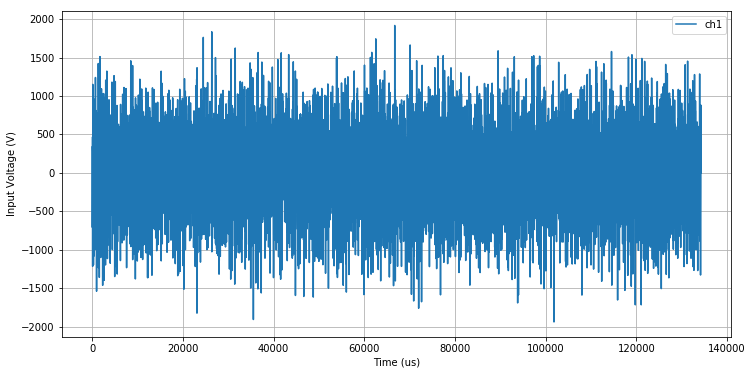

0.0305
0.0074462890625


In [5]:
waveformClkFreqMHz = round(125 / (2**waveformClkDivide),3)
t = np.arange(samples) / waveformClkFreqMHz
plt.figure(figsize=(12,6))
plt.plot(t, input_buffer_1, label = "ch1")
plt.xlabel("Time (us)")
plt.ylabel("Input Voltage (V)")
plt.grid()
plt.legend()
plt.show()
print(waveformClkFreqMHz / 2)
print(1000 * waveformClkFreqMHz / samples)

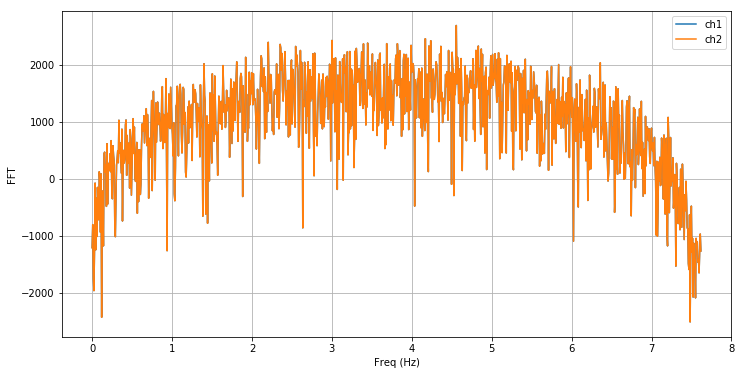

In [6]:
f = np.arange(fftDisplayPts)  * 1000 * waveformClkFreqMHz / samples
plt.figure(figsize=(12,6))
plt.plot(f, fftrim1, label = "ch1")
plt.plot(f, fftrim2, label = "ch2")
plt.xlabel("Freq (Hz)")
plt.ylabel("FFT")
plt.grid()
plt.legend()
plt.show()
